In [1]:
from functools import partial
from datasets import load_dataset
import torch
import torch.nn as nn
import numpy as np
import os
from collections import Counter
from conllu import parse_incr
import matplotlib.pyplot as plt

C:\Users\roven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Dataset Analysis: Universal Dependencies Treebank (English)


The Universal Dependencies Treebank provides a comprehensive collection of annotated sentences, allowing for analysis of linguistic features. In our analysis , we will focus on exploring the dependency relations within sentences. Before going on with this task, wlet's present a set of informative statistics about this dataset.


In [2]:
# load the dataset to be used for calculating the statistics

full_dataloader = load_dataset('universal_dependencies', 'en_lines', split='train')

Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)


1.1 Sentence Length Distribution

The distribution of sentence lengths will be the first statistic we look at. The majority of sentences, as shown in the plot, are between 9 and 15 tokens in length. The sentence that appears the most frequently is 11 tokens long.

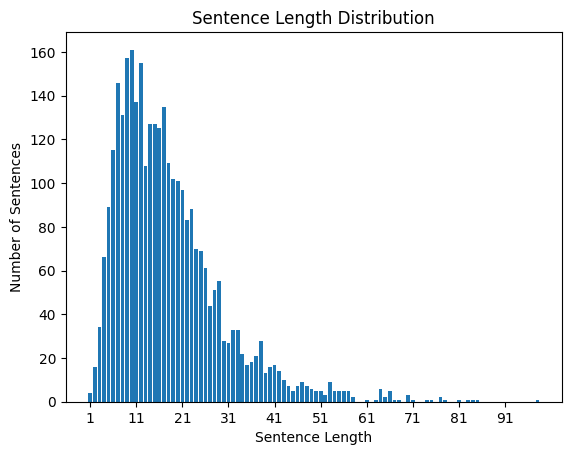

In [3]:
sentence_lengths = Counter()

for sentence in full_dataloader:
    tokens = sentence['tokens']
    length_each_sen = len(tokens)
    sentence_lengths[length_each_sen] += 1

# Extract the lengths and counts for plotting
lengths = list(sentence_lengths.keys())
counts = list(sentence_lengths.values())

# Rescale the graph with step size of 10
x_ticks = np.arange(min(lengths), max(lengths)+1, 10)

# Plot the bar graph
plt.bar(lengths, counts)
plt.xticks(x_ticks)
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.title('Sentence Length Distribution')
plt.show()

1.2 Dependency Relation Distribution

We will count the ocurrences of each dependency relation and calculate their frequencies. We can notce the dependency relations "Punctuation", "case marker", "determiner" and "nomnal subject" are commonly encountered. 

1.  Punctuation     - relationship between a word and puctuation marks in the sentence.
2.  Case Marker     - Connects a preposition to its object
3.  Determiner      - relationship between a noun and its associated determiner, which could be an article, a possessive pronoun  or other determiners like ("some", "any", "this")
4.  Nominal subject - relationship between a verb and its subject. Indicating that the noun or pronoun attached as the "nsubj" is the subject of the verb

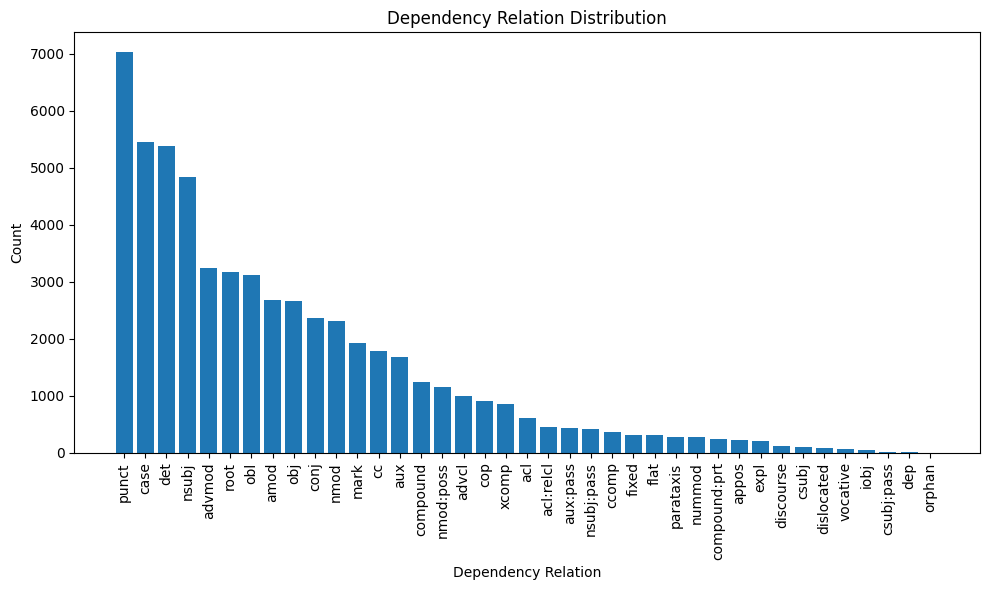

In [4]:
# Compute the distribution of dependency relations
dep_rel_counts = Counter()

for sentence in full_dataloader:
    dep_rels = sentence['deprel']
    dep_rel_counts.update(dep_rels)

# Sort the dependency relations and their counts in descending order
sorted_dep_rels, sorted_counts = zip(*sorted(dep_rel_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(sorted_dep_rels, sorted_counts)
plt.xlabel('Dependency Relation')
plt.ylabel('Count')
plt.title('Dependency Relation Distribution')
plt.xticks(rotation=90)
plt.tight_layout()  # Improve spacing between bars and labels

# Add labels to the bars
# for i, count in enumerate(sorted_counts):
    # plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

2. Arc-Eager Implementation

2.1 Parser

The Arc-Eager transition-based parsing algorithm is represented by the ArcEager class. On a given input sentence, it offers ways for performing parsing operations including shifting, left arc, right arc, and reduction. The class manages the stack, buffer, and arcs that reflect the dependence relations as well as the state of the parser.

In [5]:
class ArcEager:
    def __init__(self, sentence):

        # sentence is the input for which we want to build our Arc-Eager parser
        # it is a list of words
        

        self.sentence = sentence  
        # initialize the buffer with the indexes of the words in the sentence
        self.buffer = [i for i in range(len(self.sentence))] 
        # initialize the stack empty 
        self.stack = []
        # representation of the tree
        # every word will have a -1 assigned -> no father has been assigned yet
        self.arcs = [-1 for _ in range(len(self.sentence))]  
        # means that in the stack now is the ROOT
        self.shift() 


    def shift(self):
      """ 
      Performs the shift operation, moving a word from the buffer to the stack. 
      """

     # if len(self.buffer) > 0:
       
      b1 = self.buffer[0]
      self.buffer = self.buffer[1:]
      self.stack.append(b1)
    
    def left_arc(self): 
      """ 
      Performs the left arc operation, 
      adding an arc from the second item in the stack to the first item in the stack   
      """
  
     # if self.stack[-1] !=0 and self.arcs[self.stack[-1]]==-1:
     
      o1 = self.stack.pop()
      o2 = self.buffer[0]
      self.arcs[o1] = o2
 
    def right_arc(self):
     """
      Performs the right arc operation,
      adding an arc from the first item in the stack to the first item in the buffer
     """
     o1 = self.buffer[0]
     o2 = self.stack[-1]
     self.arcs[o1] = o2
     self.stack.append(o1)
     self.buffer = self.buffer[1:]

    def reduce(self):
     """
      Performs the reduce operation, removing the first item from the stack
     """
      # if self.arcs[self.stack[-1]] != -1:
     self.stack.pop()

    
    def is_tree_final(self):
      """
      Checks if the tree is final, i.e. if the buffer is empty and the stack contains only one item
      """
      return len(self.stack) == 1 and len(self.buffer) == 0
     
    def can_shift(self):
       result = False
       if len(self.buffer) > 0:
        return True
       return result
    def can_left_arc(self):
     result = False
     stack_top = self.stack[-1]
     if stack_top!=0 and self.arcs[stack_top]==-1:
      return True
     return result
  
    def can_right_arc(self):
     stack_len = len(self.stack)
     if stack_len > 2 and len(self.buffer) > 0:
      return True
     return False
  
    def can_reduce(self):
     result = False
     if self.arcs[self.stack[-1]] != -1:
      return True
     return result

    def print_configuration(self):
      """
      Prints the current configuration of the parser
      """

      s = [self.sentence[i] for i in self.stack]
      b = [self.sentence[i] for i in self.buffer]
      print(s,b)
      print(self.arcs)
    
      

2.2 Oracle

Based on a gold-standard tree for the arc-eager transition system, the Oracle class assists in determining the proper parsing actions. It offers ways to determine whether a left-arc, right-arc, shift, or reduction operation is the best next transition that we need to make to reach our desired tree.

It also offers helper methods to check if a word at the top of the stack has a head and if the gold-standard tree shows that it has all of its children.


In [6]:
class Oracle:
  """
  Oracle class that implements the oracle for the arc-eager transition system
  
  Args:
    parser (ArcEager): the parser
    gold_tree (list): the gold tree
    
  """
  def __init__(self, parser, gold_tree):
    
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    o1 = self.parser.stack[-1]
    o2 = self.parser.buffer[0]

    if self.gold[o1] == o2 and self.parser.arcs[o1] == -1 and o1 != -1:
      return True
    return False


  def is_right_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    o1 = self.parser.stack[-1]
    o2 = self.parser.buffer[0]

    if self.gold[o2] == o1:
      return True

    return False

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

  def is_reduce_gold(self):
    if len(self.parser.stack) < 2: 
      return False
    stack_top = self.parser.stack[-1]
    if self.has_head(stack_top) and self.has_all_children(stack_top):
      return True
    return False

  def has_head(self, stack_top):
    return  self.parser.arcs[stack_top] != -1 


  def has_all_children(self, stack_top):
    i = 0
    for arc in self.gold:
      if arc == stack_top:
        if self.parser.arcs[i] != stack_top:
          return False
      i+=1
    return True
  

2.3 Testing the Parser and Oracle

We will show how the parser and Oracle work together to analyze a given sentence and create the corresponding dependence structure. The gold-standard (reference) dependency structure and the created dependency structure will be compared.

In [7]:
sentence = ["<ROOT>", "He","began","to","write","again","."]
gold = [-1, 2, 0, 4, 2, 4, 2]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

while not parser.is_tree_final():
    if oracle.is_left_arc_gold():
        parser.left_arc()
    elif oracle.is_right_arc_gold():
        parser.right_arc()
    elif oracle.is_reduce_gold():
        parser.reduce()
    elif oracle.is_shift_gold():
        parser.shift()
        
print(parser.arcs)
print(gold)
    

[-1, 2, 0, 4, 2, 4, 2]
[-1, 2, 0, 4, 2, 4, 2]


2.4 Useful functions

This algorithm is designed based on the assumption of projective trees. To make parsing decisions accurately it relies on the non-crossing property of dependencies. It is therefore essential to understand if a tree is projective or not. Later, the sentences that are not projective will be eliminated using this function.

A dictionary of words is created from a dataset using the create_dict function, but only those words that appear more frequently than the threshold are included. Each word in the dictionary is given a distinct index, with additional entries for padding, the root token, and unidentified terms.

In [8]:
def is_projective(tree):
    """
    Checks if a tree is projective or not
    """
    for i in range(len(tree)):
        if tree[i]==-1:
            continue
        left = min(i, tree[i])
        right = max(i, tree[i])

        for j in range(0, left):
            if tree[j] > left and tree[j] < right:
                return False
        for j in range(left+1, right):
            if tree[j] < left or tree[j] > right:
                return False
        for j in range(right+1, len(tree)):
            if tree[j] > left  and tree[j] < right:
                return False
    return True


In [9]:
def create_dict(dataset, threshold = 3):

    """ ceate a dictionary of words with frequency >= threshold
    """
    
    dic = {}

    for sample in dataset:
        for word in sample['tokens']:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 1
    
    map = {}
    map["<pad>"] = 0
    map["<ROOT>"] = 1
    map["<unk>"] = 2

    next_indx = 3
    for word in dic.keys():
        if dic[word] >= threshold:
            map[word] = next_indx
            next_indx += 1
    return map

3. BiLSTM Model

The first thing we need to do, before going on with the development of our model is to get the data. The following actions are performed by the code below:

1. Loading Datasets: The code loads three datasets, namely train_dataset, dev_dataset, and test_dataset, from the 'universal_dependencies' dataset using the 'en_lines' treebank. 

2. Removing Non-Projective Sentences: The code filters the train_dataset to remove non-projective sentences using the 'is_projective' function. Only the projective sentences are retained in the train_dataset.

3. Creating an Embedding Dictionary: The code creates an embedding dictionary, emb_dictionary, based on the filtered train_dataset. The dictionary contains words with frequencies above a certain threshold and assigns unique indices to each word, including special entries for padding, the root token, and unknown words. This dictionary will be used for word embedding during further processing.

Lastly, we print the size of each dataset used.

In [10]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'test')

# remove non-projective sentences: heads in the gold 
# tree are strings, we convert them to int

train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample['head']])]

# create embedding dictionary

emb_dictionary = create_dict(train_dataset)


print("Number of samples:")
print("Train:\t", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)


Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


The process_sample function processes a single sample from a dataset, preparing it for further processing or training. It takes a sample dictionary as input and returns the encoded sentence, gold path (configuration), gold moves, and gold tree information.

In [11]:
def process_sample(sample:dict, get_gold_path = False):
  """
  Process one sample from the dataset
  Args:
    sample (dict): sample from the dataset
    get_gold_path (bool): whether to get gold path for training
  Returns:
    enc_sentence (list): list of word ids
    gold_path (list): list of configurations
    gold_moves (list): list of oracle moves
  """
  

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  
  
  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   
  gold_moves = []  

  if get_gold_path:  
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      
      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])  
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold(): 
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)

  return enc_sentence, gold_path, gold_moves, gold

    


The prepare_batch function processes a batch of data by applying the process_sample function to each sample and extracts the necessary information to separate lists for sentences, paths, moves, and trees.

In [12]:
def prepare_batch(batch_data, get_gold_path = False):
    """
    Prepare batch for training
    Args:
      batch_data (list): list of samples from the dataset
      get_gold_path (bool): whether to get gold path for training
    Returns:
        sentences (list): list of word ids
        paths (list): list of configurations
        moves (list): list of oracle moves
        trees (list): list of gold trees
    """
    data = [process_sample(s, get_gold_path = get_gold_path) for s in batch_data]

    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]

    return sentences, paths, moves, trees

Here we set up data loaders for training, development, and testing datasets with a batch size of 32. Additionally, we define the hyperparameters for the neural network, showing the values that yield the best results. 

In [13]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch, get_gold_path = True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch))

In [14]:
# define hyperparameters of NN
EMBEDDING_SIZE = 400
LSTM_SIZE = 400
LSTM_LAYERS = 2
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001

After preparing the data, we will give the sentence to BiLSTM to obtain some contextual representation and then we will use Feed-Forward to score the parser configuration and what is the best transition to do next.




In [15]:
class Net(nn.Module):
  """
  Network for transition-based dependency parsing
  """
  def __init__(self, device):
  
    """
    Args:
      device (str): device to run the network on (cpu or cuda)
      
    """
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    """
    Forward pass of the network
    Args:
      x (list): list of word ids
      paths (list): list of configurations
    Returns:
      tensor: scores for each possible action
    """
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    """
    Run the bi-lstm
    Args:
      x (list): list of word embeddings
    Returns:
      tensor: output of the bi-lstm
    """
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    """
    Arrange the input for the feedforward
    Args:
      configurations (list): list of configurations
      h (tensor): output of the bi-lstm
    Returns:
      tensor: input for the feedforward
    """
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)

    # Create a list comprehension to construct mlp_input directly
    mlp_input = [torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i],
                            zero_tensor if j[1]==-1 else h[j[1]][i],
                            zero_tensor if j[2]==-1 else h[j[2]][i]])
                 for i in range(len(configurations))
                 for j in configurations[i]]

    # Convert the list to a tensor
    mlp_input = torch.stack(mlp_input).to(self.device)
    
    return mlp_input

  def mlp(self, x):
    """ 
    Feedforward function
    Args:
      x (tensor): input tensor
    Returns:
      tensor: output tensor
    """
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model

  def infere(self, x):
    """
    Inference function
    Args:
      x (list): list of sentences
    Returns:
      list: list of predicted dependency trees   
    """

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    """
    Get the configurations for each parser  """

    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    """ 
      Check if all parsers have parsed the whole sentence  """
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True


  def parse_step(self, parsers, moves):
      """
      Apply the best possible move to each parser

      :param parsers: list of parsers
      :param moves: list of moves scores for each parser
      
      """
      moves_argm = moves.argmax(-1)
      for parser, move_arg in zip(parsers, moves_argm):
        if parser.is_tree_final():
          continue

        stack_len = len(parser.stack)
        buffer_len = len(parser.buffer)
        stack_top = parser.stack[-1]

        if move_arg == 0:
          if buffer_len > 0 and stack_top != 0:
            parser.left_arc()
          else:
            self.apply_default_move(parser, stack_len, buffer_len)
        elif move_arg == 1:
          if stack_len >= 2 and buffer_len > 0:
            parser.right_arc()
          else: 
            self.apply_default_move(parser, stack_len, buffer_len)
        elif move_arg == 2:
          if buffer_len > 0:
            parser.shift()
          else:
            self.apply_default_move(parser, stack_len, buffer_len)
        elif move_arg == 3:
          if stack_len >= 2:
            parser.reduce()
          else:
            self.apply_default_move(parser, stack_len, buffer_len)

  def apply_default_move(self, parser, stack_len, buffer_len):

    """Apply the default move if the predicted move is not possible."""	

    stack_top = parser.stack[-1]
    if buffer_len > 0:
      if stack_top != 0:
        parser.left_arc()
      else:
        parser.shift()
    elif stack_len >= 2:
      parser.reduce()
    else:
      parser.shift()

In [16]:
# Evaluation
def evaluate(gold, preds):
 """Evaluate the model performance on the test set."""	

 total = 0
 correct = 0

 for g, p in zip(gold, preds):
  for i in range(1,len(g)):
    total += 1
    if g[i] == p[i]:
     correct += 1

 return correct/total

# Training
def train(model, dataloader, criterion, optimizer):

  """Train the model on the training set."""	

  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    """Train the model on the training set."""

    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test(model, dataloader):
  """Evaluate the model performance on the test set."""
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cpu
Epoch:   0 | avg_train_loss: 1.000 | dev_uas: 0.514 |
Epoch:   1 | avg_train_loss: 0.901 | dev_uas: 0.618 |
Epoch:   2 | avg_train_loss: 0.873 | dev_uas: 0.626 |
Epoch:   3 | avg_train_loss: 0.856 | dev_uas: 0.652 |
Epoch:   4 | avg_train_loss: 0.840 | dev_uas: 0.677 |
Epoch:   5 | avg_train_loss: 0.826 | dev_uas: 0.686 |
Epoch:   6 | avg_train_loss: 0.817 | dev_uas: 0.689 |
Epoch:   7 | avg_train_loss: 0.809 | dev_uas: 0.696 |
Epoch:   8 | avg_train_loss: 0.802 | dev_uas: 0.704 |
Epoch:   9 | avg_train_loss: 0.798 | dev_uas: 0.700 |
Epoch:  10 | avg_train_loss: 0.793 | dev_uas: 0.704 |
Epoch:  11 | avg_train_loss: 0.790 | dev_uas: 0.709 |
Epoch:  12 | avg_train_loss: 0.787 | dev_uas: 0.711 |
Epoch:  13 | avg_train_loss: 0.784 | dev_uas: 0.707 |
Epoch:  14 | avg_train_loss: 0.782 | dev_uas: 0.714 |


The Unlabeled Attachment score, which provides a measure of the parser's ability to correctly identify the syntactis heads of words in a sentence, obtained by the first model is 0.71.  

In [53]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas))

test_uas: 0.714


4. BERT-based Model

4.1 Tokenize dataset before feeding to a Transformer

In [17]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'test')


Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)


In [18]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")

train_dataset = train_dataset.map(
    lambda example: tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        return_tensors="pt"
    ),
    batched=True,
)

dev_dataset = dev_dataset.map(
    lambda example: tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        return_tensors="pt"
    ),
    batched=True,
)

test_dataset = test_dataset.map(
    lambda example: tokenizer(
        example["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        return_tensors="pt"
    ),
    batched=True,
)


Loading cached processed dataset at C:\Users\roven\.cache\huggingface\datasets\universal_dependencies\en_lines\2.7.0\1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7\cache-f5e93fb390b13bcd.arrow
Loading cached processed dataset at C:\Users\roven\.cache\huggingface\datasets\universal_dependencies\en_lines\2.7.0\1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7\cache-b36fdcf028af0e18.arrow
Loading cached processed dataset at C:\Users\roven\.cache\huggingface\datasets\universal_dependencies\en_lines\2.7.0\1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7\cache-92fd0ac2342b5042.arrow


In [19]:
def prepare_batch_bert(batch_data, get_gold_path=False):
  """Prepare the batch for the model.

  :param batch: batch of sentences
  :return: sentences, paths, moves, trees
  """
  data = [process_sample(s, get_gold_path = get_gold_path) for s in batch_data]
  sentences = [s[0] for s in data]
  paths =  [s[1] for s in data]
  moves =  [s[2] for s in data]
  trees =  [s[3] for s in data]
  input_ids = [s[4] for s in data]
  connectors = [s[5] for s in data]
  attention_mask = [s[6] for s in data]
  return input_ids, connectors, attention_mask, paths, moves, trees, sentences

In [20]:
BATCH_SIZE = 32

train_dataloader_bert = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert, get_gold_path = True))
dev_dataloader_bert = torch.utils.data.DataLoader(dev_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert))
test_dataloader_bert = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert))

In [21]:
from transformers import BertModel, BertTokenizer

class Bert(nn.Module):
  """
  Network for transition-based dependency parsing using BERT embeddings
  """
  def __init__(self, device):
    super(Bert, self).__init__()
    self.device = device
    self.bert_model = BertModel.from_pretrained("bert-base-uncased")
    self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    for param in self.bert_model.encoder.layer[:5].parameters():
      param.requires_grad = False
      

    self.w1 = torch.nn.Linear(768, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    
    self.dropout = torch.nn.Dropout(DROPOUT)
    
  def forward(self, x, paths, connector, attention_mask):

    # Pass the input through the BERT model to get embeddings

    outputs = self.bert_pass(x, attention_mask=attention_mask)

    # Run the feedforward network on the word embeddings
    mlp_input = self.get_mlp_input(paths, outputs, connector)
    out = self.mlp(mlp_input)
    
    return out
    
  def bert_pass(self, x, attention):
    # Tensor initialization
    x = x.squeeze(0).to(self.device) 
    attention =  attention.squeeze(0).to(self.device)

    # BERT pass and last layers extraction
    outputs = self.bert_model(input_ids = x)
    summed_last_3_layers = torch.stack(outputs.last_hidden_state[-3:]).sum(0)

    # (batch, len_sent, hid) -> (len_sent, batch, hid)
    outputs = summed_last_3_layers.permute(1, 0, 2)

    return outputs

  def get_mlp_input(self, configurations, outputs, connector):
    mlp_input = []
    zero_tensor = torch.zeros(768, requires_grad=False).to(self.device)
    
    for i in range(len(configurations)):
      for j in configurations[i]:
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else outputs[ connector[i][ j[0] ] ][i],
                                    zero_tensor if j[1]==-1 else outputs[ connector[i][ j[1] ] ][i],
                                    zero_tensor if j[2]==-1 else outputs[ connector[i][ j[2] ] ][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, x, attention, connector):
    parsers = [ArcEager(i) for i in x]
    
    outputs = self.bert_pass(x, attention)
    
    while not self.parsed_all(parsers):
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, outputs, connector)
      mlp_out = self.mlp(mlp_input)
      self.parse_step(parsers, mlp_out)

    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for parser, move_arg in zip(parsers, moves_argm):
      if parser.is_tree_final():
        continue

      stack_len = len(parser.stack)
      buffer_len = len(parser.buffer)
      stack_top = parser.stack[-1]

      if move_arg == 0:
        if buffer_len > 0 and stack_top != 0:
          parser.left_arc()
        else:
          self.apply_default_move(parser, stack_len, buffer_len)
      elif move_arg == 1:
        if stack_len >= 2 and buffer_len > 0:
          parser.right_arc()
        else: 
          self.apply_default_move(parser, stack_len, buffer_len)
      elif move_arg == 2:
        if buffer_len > 0:
          parser.shift()
        else:
          self.apply_default_move(parser, stack_len, buffer_len)
      elif move_arg == 3:
        if stack_len >= 2:
          parser.reduce()
        else:
          self.apply_default_move(parser, stack_len, buffer_len)

  def apply_default_move(self, parser, stack_len, buffer_len):
    stack_top = parser.stack[-1]
    if buffer_len > 0:
      if stack_top != 0:
        parser.left_arc()
      else:
        parser.shift()
    elif stack_len >= 2:
      parser.reduce()
    else:
      parser.shift()


In [22]:
MLP_SIZE = 1
DROPOUT = 0.2
EPOCHS = 4 
LR = 3e-3

In [23]:
def train_bert(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    count = 0

    for batch in dataloader:
        optimizer.zero_grad()
        indices_ids, paths, moves, trees, connector, attention_mask = batch

        out = model(indices_ids, paths, connector, attention_mask)
        labels = torch.tensor(sum(moves, [])).to(model.device)  # Flatten the moves list
        loss = criterion(out, labels)

        count += 1
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / count


def test_bert(model, dataloader):
    model.eval()

    gold = []
    preds = []
    for batch in dataloader:
        indices_ids, paths, moves, trees, connector, attention_mask = batch
        with torch.no_grad():
          pred = model.infere(indices_ids, attention_mask, connector)
          gold += trees
          preds += pred

    return evaluate(gold, preds)



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Bert(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train_bert(model, train_dataloader_bert, criterion, optimizer)
  val_uas = test_bert(model, dev_dataloader_bert)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cpu


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
